# INSTALAÇÕES ☕

Executar todo o código no PyCharm ou Jupyter

- https://www.youtube.com/watch?v=yl2WiFbZhPs

In [ ]:
pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
# @title
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import f
import statsmodels.stats.stattools as stattools
import statsmodels.stats.stattools as st
from scipy.stats import shapiro
from numpy import arange
from scipy.optimize import curve_fit
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import PredictionErrorDisplay
from pandas import DataFrame as df
import seaborn as sns
import pingouin as pg

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

# Organizando os dados

In [ ]:
# @title

def ler_planilha (path, planilha, coluna_Inicio,coluna_Fim,linha_Inicio,linha_Fim):
    plan_principal = pd.read_excel(path, sheet_name= planilha,usecols=coluna_Inicio +':' + coluna_Fim, skiprows= linha_Inicio, nrows= linha_Fim)
    plan_principal = plan_principal.apply(pd.to_numeric, errors='coerce')# Converter as colunas para formato numérico, se necessário
    return plan_principal

# Exemplo
amostras = ler_planilha('/content/drive/MyDrive/ xxxxx.xlsm', 'xxxxx', 'x', 'x', 75, 88)
# https://www.medcalc.org/download/

# Curva de Calibração
- https://www.tutorialspoint.com/python/python_data_types.htm
- https://machinelearningmastery.com/curve-fitting-with-python/

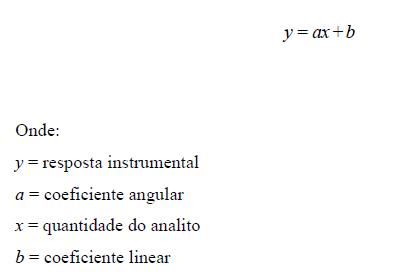

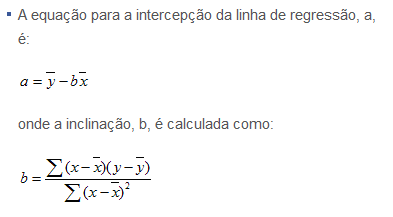

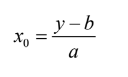

           y = 14795.76 x + 157.76
           R² = 0.999


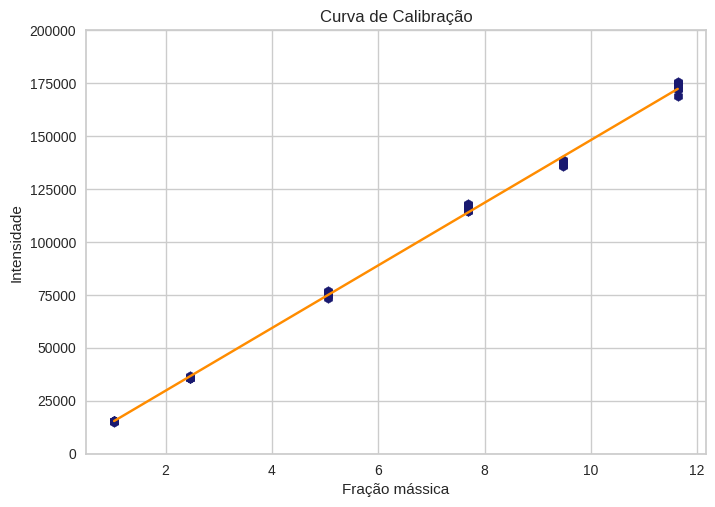

In [ ]:
from re import X
# @title
curve = ler_planilha('insira os dados', 'insira os dados', 'insira os dados', 'insira os dados', 0, 0)
curve = curve.apply(pd.to_numeric, errors='coerce')#.drop([0,1,2,3,4,5,6], axis=0)
# curve.rename(columns={'Unnamed: 0': 'Concentração'}, inplace=True), curve.rename(columns={'Unnamed: 2': 'Intensidade'}, inplace=True)
# curve = curve.fillna("")

x_eixo = curve.iloc[:, 0].values
y_eixo = curve.iloc[:, 1].values
corr = np.corrcoef(x_eixo,y_eixo)
corr = corr.reshape(1,-1)
x_medio = x_eixo.mean()
y_medio = y_eixo.mean()

inclinação = sum((x_eixo - x_medio)*(y_eixo - y_medio))/sum((x_eixo - x_medio)**2)
intercepto = y_medio - inclinação * x_medio

plt.scatter(x_eixo, y_eixo, color='MidnightBlue', marker='h')
plt.xlabel("Fração mássica")
plt.ylabel("Intensidade")
plt.title("Curva de Calibração")

plt.ylim(0, 200000)

plt.plot(x_eixo, inclinação * x_eixo + intercepto, color = 'DarkOrange')
print("           y = " + str(inclinação.round(2)) + " x + " + str(intercepto.round(2)) +'\n'+'           R² = '+str(corr[0][1].round(3)))
# y = (inclinação * x_eixo) + intercepto


# Análise das Amostras ⚗

In [ ]:
# @title
amostras = ler_planilha()
amostras = amostras.fillna("").drop([7,8,9,10,12,13]).drop('Unnamed: 0', axis=1).drop('Unnamed: 1', axis=1).apply(pd.to_numeric, errors='coerce')
fd = amostras.loc[11]
Wa = ((amostras - intercepto)/inclinação)*fd.values
Wa = Wa.drop([11])
Wa_medio = pd.DataFrame(Wa.mean(), columns=['mg/kg'])
print('Concentrações das amostras','\n')
display(Wa_medio)

Concentrações das amostras 



,mg/kg
AMA,NaN
AMB,NaN
CCQM K56A,NaN
CCQM K56B,NaN
Unnamed: 6,NaN
Unnamed: 7,NaN
Unnamed: 8,NaN
Unnamed: 9,NaN
Unnamed: 10,NaN
Unnamed: 11,NaN


# Teste de Grubbs

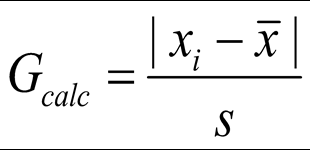


- _> maior que

- _< menor que

In [ ]:
# @title
critical_values = pd.read_csv('Valores_críticos_de_Grubbs.csv')
from scipy.stats import norm
# Função para obter o valor crítico
def g_tabelado(n, alpha=0.05):
    critical_values['α'] = pd.to_numeric(critical_values['α'], errors='coerce')
    valid_rows = critical_values[critical_values['α'].notna()]  # Filter out NaN values
    row = valid_rows[valid_rows['α'] == n]  # Now compare with numeric values
    if row.empty:
        raise ValueError("Não há valores críticos para n = %d" % n)
    if alpha == 0.05:
        return row['0.05'].values[0]
    elif alpha == 0.01:
        return row['0.01'].values[0]
    else:
        raise ValueError("Alpha deve ser 0.05 ou 0.01")

# critical_value = g_tabelado(n, alpha) ----> exemplo de uso

In [ ]:
# @title
# intab é 'intensidades' + 'tabela', fica esperta

intab  =  ler_planilha()
intab = intab.drop('Branco', axis=1)
intab = intab.set_index("Replicatas")
n = len(intab)

# Valores estatísticos
mediasT = intab.mean().round(2)
devPad = np.std(intab,axis=0, ddof=1).round(2)
maximos = intab.max().round(2)
minimos = intab.min().round(2)
variancia = intab.var().round(2)

z = (mediasT - intab) / devPad
gmin = (mediasT - minimos) / devPad
gmax = (maximos - mediasT) / devPad

# Calcular o valor crítico

alpha = 0.05 # nível de significância do teste
critical_value = g_tabelado(n, alpha) # valor crítico oriundo de uma tabela para n=7 e 95% de confiança (7 --> 0.05)

# Calcula G e Outlier para cada padrão
G_values = []
outliers = []

for i in range(len(intab.columns)):
    G_max = gmax.iloc[i]
    G_min = gmin.iloc[i]

    outlier_max = 'Sim' if G_max > critical_value else 'Não'
    outlier_min = 'Sim' if G_min > critical_value else 'Não'

    if outlier_max == 'Sim' and outlier_min == 'Sim':
        G = G_max if abs(G_max) > abs(G_min) else G_min
        outlier = 'Sim'
    elif outlier_max == 'Sim':
        G = G_max
        outlier = 'Sim'
    elif outlier_min == 'Sim':
        G = G_min
        outlier = 'Sim'
    else:
        G = G_max  # Default value if no outliers
        outlier = 'Não'

    G_values.append(G.round(4))
    outliers.append(outlier)

df = len(z) - 1
p = (1 - norm.cdf(abs(z)))*2

# Initialize a dictionary to store p-values
p_values_dict = {}

for column in z.columns[0:]:  # Iterate over columns starting from the first
    p_values = 2 * (1 - norm.cdf(abs(z[column])))   # Calculate two-sided p-values
    p_values_dict[column] = p_values  # Store p-values in the dictionary
    # print(f"P-values for {column}: {p_values}")

# Create a DataFrame from the p-values dictionary
p_values_df = pd.DataFrame(p_values_dict)

# Create a DataFrame for G_values
G_values_df = pd.DataFrame(G_values, columns=['G'], index=intab.columns)

# Apply styling to G_values_df
# Apply styling to G_values_df
def highlight_outlier(G):
    if G.iloc[0] > critical_value:  # Access the value using index location
        return ['background-color: purple']
    return ['']

def highlight_outlier_p(p):
    styles = []
    for value in p:  # Iterate over values in the column
        if value < alpha:
            styles.append('background-color: purple')
        else:
            styles.append('')
    return styles  # Return a list of styles for the entire column

styled_p_values_df = p_values_df.style.apply(highlight_outlier_p, axis=1)  # Apply along axis 0 (columns)
# display(styled_p_values_df)

styled_G_values_df = G_values_df.style.apply(highlight_outlier, axis=1)
# styled_p_values_df = p_values_df.style.apply(highlight_outlier_p, axis=1)

estatisticas_gerais = pd.DataFrame(
    [mediasT, devPad, gmin.round(3), gmax.round(3)],
    index = ['Média', 'Desvio Padrão', 'Gmin', 'Gmax'])
estatisticas_gerais.loc['Outlier'] = outliers
valor_critico_intab = pd.DataFrame([critical_value], index=['Valor Crítico'])
intab = pd.concat([intab, valor_critico_intab, estatisticas_gerais])
intab = intab.fillna("")
intab.rename(columns={0: 'Estatísticas'}, inplace=True)

# display(styled_G_values_df)
print('                        Valores de P','\n','\n','Se P < 0.05, então existe outlier','\n')
display(styled_p_values_df)
print('\n')
display(intab)

                        Valores de P 
 
 Se P < 0.05, então existe outlier 



,Padrão 1,Padrão 2,Padrão 3,Padrão 4,Padrão 5,Padrão 6
0,0.446002,0.408069,0.067883,0.170410,0.636274,0.066727
1,0.525465,0.889212,0.462135,0.298618,0.477873,0.621454
2,0.694297,0.316793,0.875737,0.953335,0.194482,0.639181
3,0.459455,0.425257,0.655848,0.360985,0.306516,0.766201
4,0.143501,0.317901,0.305019,0.417135,0.635638,0.407766
5,0.821922,0.887743,0.414682,0.242803,0.188466,0.431678
6,0.145016,0.104150,0.666894,0.671515,0.442550,0.376354


,Padrão 1,Padrão 2,Padrão 3,Padrão 4,Padrão 5,Padrão 6,Estatísticas
1,15267.13143,35715.80143,73439.33143,114422.9514,137847.3714,168777.8914,
2,15528.81143,35946.34143,74709.57143,114855.2014,136493.4114,172028.9614,
3,15336.26143,35657.57143,75383.99143,116134.2514,135820.5714,172089.5014,
4,15548.44143,35725.84143,76085.28143,117401.7314,136135.2614,173948.8114,
5,15683.89143,36327.70143,76761.00143,117268.6114,137848.3914,175236.1314,
6,15367.72143,36040.32143,76516.32143,117733.6214,138811.5914,175135.4014,
7,15136.90143,36537.56143,76067.53143,115657.5814,138185.0814,175373.9714,
Valor Crítico,,,,,,,2.02
Média,15409.88,35993.02,75566.15,116210.56,137305.95,173227.24,
Desvio Padrão,187.31,335.09,1164.88,1303.98,1144.86,2426.69,


# Shapiro wilk - teste de Normalidade

http://www.sthda.com/english/rsthda/shapiro-wilk.php

https://scistatcalc.blogspot.com/2013/10/shapiro-wilk-test-calculator.html

https://real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/shapiro-wilk-test/

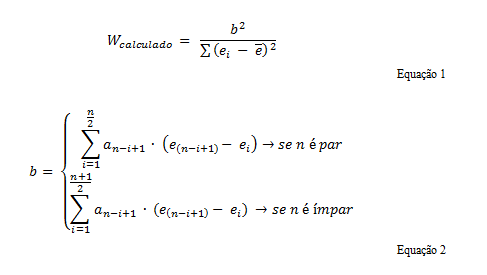

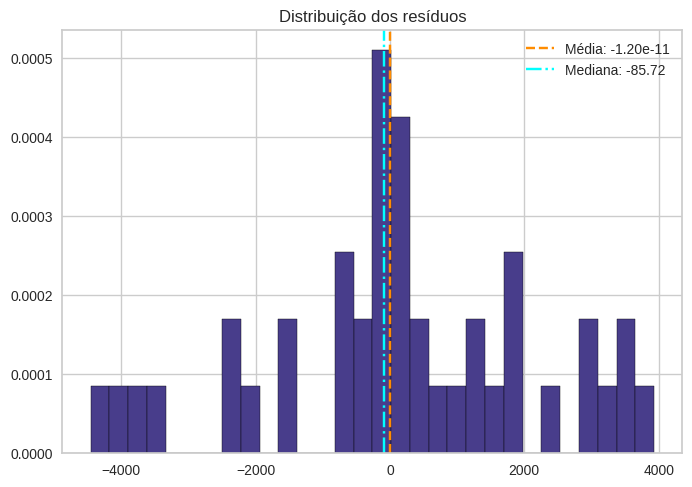

,Resultados
Estatística W,0.96662
Valor p,0.25316
Distribuição Normal,Sim


In [ ]:

# @title
# método do Pandas
# resultados satisfatórios (?)

# Cálculo dos resíduos
y_lido = curve.iloc[:, 1].values
yesp = (inclinação * x_eixo) + intercepto
ajuste_curva = y_lido-yesp.flatten()

ajuste_curva = pd.DataFrame(ajuste_curva)
ajuste_curva.rename(columns={0: 'Resultados'}, inplace=True)
ajuste_curva

def shapiro_teste(ajuste_curva):
    stat, p = shapiro(ajuste_curva)
    if p > 0.05:
        return True
    else:
        return False

def shapiro_estatistica(ajuste_curva):
    stat, p = shapiro(ajuste_curva)
    return stat

def shapiro_p(ajuste_curva):
    stat, p = shapiro(ajuste_curva)
    return p

def shapiro_df(ajuste_curva):
    estatisticas_shapiro = ajuste_curva.apply(shapiro_estatistica)
    estatisticas_df = pd.DataFrame([estatisticas_shapiro], index=['Estatística W'])
    # ajuste_curva = pd.concat([ajuste_curva, estatisticas_df])

    p_shapiro = ajuste_curva.apply(shapiro_p)
    p_df = pd.DataFrame([p_shapiro], index=['Valor p'])
    resultados = pd.concat([estatisticas_df, p_df])

    # resultados e conclusões
    normal_shapiro = ajuste_curva.apply(shapiro_teste).apply(lambda x: "Sim" if x else "Não")
    normal_df = pd.DataFrame([normal_shapiro], index=['Distribuição Normal'])
    resultados = pd.concat([resultados, normal_df])
    return resultados
    # resultados e conclusões
resultados = shapiro_df(ajuste_curva)
# print(resultados, '\n')

mean_value = np.mean(ajuste_curva)
median_value = np.median(ajuste_curva)
# Adiciona linhas de média e mediana
plt.axvline(mean_value, color='darkorange', linestyle='--', label=f'Média: {mean_value:.2e}')
plt.axvline(median_value, color='cyan', linestyle='-.', label=f'Mediana: {median_value:.2f}')
plt.hist(ajuste_curva, bins=30, align='right', color='DarkSlateBlue', edgecolor='black', density=True)
plt.title('Distribuição dos resíduos')
plt.legend()
# sns.kdeplot(ajuste_curva);
plt.show()
resultados


# Homocedasticidade - Cochran

In [ ]:
# @title
import numpy as np

# f'{SQreg:.2e}' <<<<<<<< NOTAÇÃO CIENTÍFICA

plan_principal = ler_planilha ()
plan_principal = plan_principal.drop('Branco', axis=1)
# plan_principal = plan_principal.drop('Padrão 5').max()
plan_principal = plan_principal.set_index("Replicatas") #plan_principal.set_index("Replicatas", inplace=True)


variances = plan_principal.var().round(2)
max_variance = variances.max()
sum_variances = variances.sum()
cochrane_statistic = max_variance / sum_variances

variances_df = pd.DataFrame([variances], index = ['Variância'])
variances = pd.concat([plan_principal, variances_df])

max_variance = variances.loc['Variância'].max()
variance_max_df= pd.DataFrame([max_variance], index = ['Variância Max'])
variances = pd.concat([variances, variance_max_df])

min_variance = variances.loc['Variância'].min()
variance_min_df= pd.DataFrame([min_variance], index = ['Variância Min'])
variances = pd.concat([variances, variance_min_df])

soma_variances = variances.loc['Variância'].sum()
soma_variances_df= pd.DataFrame([soma_variances], index = ['Soma das Variâncias'])
variances = pd.concat([variances, soma_variances_df])

# sum_variances = variances.loc['Variância'].sum()

# o valor estatístico de cochran
cochrane_statistic = max_variance / sum_variances
# valor de cochran tabelado ( n=7 e p=6 )
valor_critico = 0.4194
variances = pd.DataFrame([valor_critico], index = ['Valor Crítico'])
variances = pd.concat([variances])
cochrane_statistic_df= pd.DataFrame([cochrane_statistic], index = ['Cochrane Estatistica'])
variances = pd.concat([variances, cochrane_statistic_df])

# valor de cochran tabelado ( n= 7 e p= 6 )


if (cochrane_statistic < valor_critico).all():
    Resultado = "HOMOCEDÁSTICO"
    Resultado_df = pd.DataFrame([Resultado], index = ['Resultado'])
    variances = pd.concat([variances, Resultado_df])
else:
    Resultado = "Não HOMOCEDÁSTICO"
    Resultado_df= pd.DataFrame([Resultado], index = ['Resultado'])
    variances = pd.concat([variances, Resultado_df])

variances = variances.fillna("")
variances.rename(columns={0: 'Estatísticas'}, inplace=True)

# plan_principal

variances

,Estatísticas
Valor Crítico,0.4194
Cochrane Estatistica,0.566003
Resultado,Não HOMOCEDÁSTICO


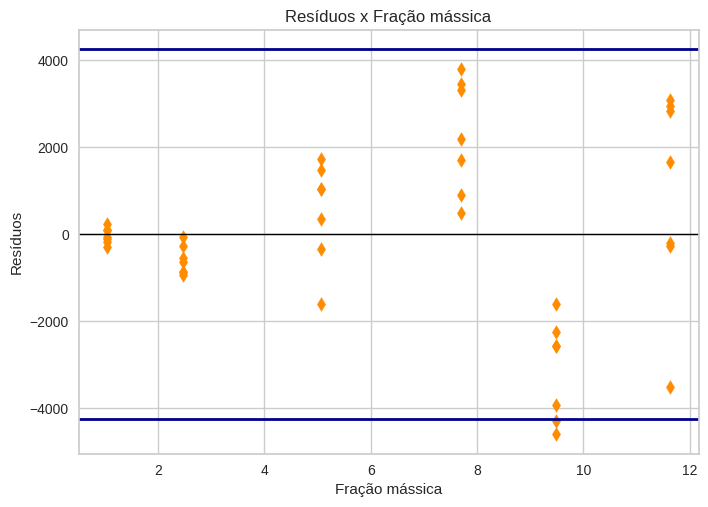

In [ ]:
# @title

from scipy.stats import t
gres = ler_planilha()
gres = gres.apply(pd.to_numeric, errors='coerce')
# gres.rename(columns={'Unnamed: 0': 'Concentração'}, inplace=True), gres.rename(columns={'Unnamed: 2': 'Intensidade'}, inplace=True)
gres = gres.fillna("")


gx = gres.iloc[:, 0].values
gy = gres.iloc[:, 1].values

corr = np.corrcoef(gx, gy)

gx = gx.reshape(-1,1)
model = LinearRegression()

model.fit(gx, gy)

gy_pred = model.predict(gx).round(3)

y_lido = curve.iloc[:, 1].values
yesp = (inclinação * x_eixo) + intercepto
res = y_lido-yesp.flatten()


sres2 = sum(res**2)/(len(res)-2)
sres = np.sqrt(sres2)
tdist = stats.t.ppf(1 - 0.05/2, (len(res)-2))
t_sres = tdist * sres
limite_superior = res.mean()+t_sres
limite_inferior = res.mean()-t_sres

# limite_superior = np.mean(res) + 3 * np.std(res, ddof=1) # 3 vezes o desvio em torno da média para uma abrangência de 99%
# limite_inferior = np.mean(res) - 3 * np.std(res, ddof=1)

plt.axhline(limite_superior, color='darkblue', linestyle='-', linewidth=2)
plt.axhline(limite_inferior, color='darkblue', linestyle='-', linewidth=2)
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.scatter(gx,res, color='darkorange', marker='d')
plt.xlabel("Fração mássica")
plt.ylabel("Resíduos")
plt.title("Resíduos x Fração mássica")
plt.legend()
# plt.grid(False)
plt.plot(x_eixo, res,color='None')



In [ ]:
# help(plt.plot)

# ANOVA    
ANOVA bidirecional: Em palavras simples, ANOVA é um teste realizado em estatística e é utilizado para interpretar a diferença entre o valor médio de pelo menos três grupos. O objetivo principal de uma ANOVA bidirecional é descobrir como dois fatores afetam uma variável de resposta e descobrir se existe uma relação entre os dois fatores na variável de resposta.

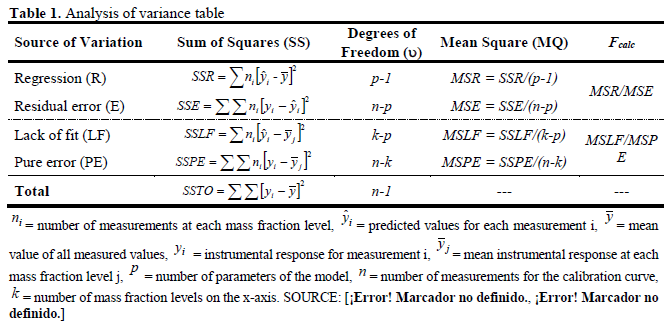

In [ ]:
# @title
tst_anova = ler_planilha ()


p = 2  # p = número de parâmetros do modelo
n = 42 # n = número de medições por cada nível de fração mássica, que neste caso é 42
m =	6  # m = número de frações mássicas (PADRÕES) no eixo x. Em alguns casos este parâmetro aparece como 'k'

graus_de_liberdade = [p-1,n-p ,m-p, n-m , n-1 ]
somatorios = tst_anova.sum()

media_quadratica = somatorios / graus_de_liberdade

media_quadratica_df = pd.DataFrame([media_quadratica], index=['Média Quadrática'])
# tst_anova = pd.concat([tst_anova, media_quadratica_df])

estatisticas_gerais.rename(columns={0: 'Resultados'}, inplace=True)

SQreg = tst_anova['[(ye)i - ym]2'].sum()
SQreg_df = pd.DataFrame([f'{SQreg:.2e}'], index=['SQ regressão'])
#tst_anova = pd.concat([tst_anova, SQreg_df])

SQr = tst_anova['[yij-(ye)i]2'].sum()
SQr_df = pd.DataFrame([f'{SQr:.2e}'], index=['SQ Erro residual'])
#tst_anova = pd.concat([tst_anova, SQr_df])

SQfaj= tst_anova['[(ye)i-yim]2'].sum()
SQfaj_df = pd.DataFrame([f'{SQfaj:.2e}'], index=['SQ falta de ajuste'])
#tst_anova = pd.concat([tst_anova, SQfaj_df])

SQep = tst_anova['(yij-yim)2'].sum()
SQep_df = pd.DataFrame([f'{SQep:.2e}'], index=['SQ erro puro'])
#tst_anova = pd.concat([tst_anova, SQep_df])

SQt = tst_anova['(yij-ym)2'].sum()
SQt_df = pd.DataFrame([f'{SQt:.2e}'], index=['SQ total'])
#tst_anova = pd.concat([tst_anova, SQt_df])

estatisticas_gerais = pd.DataFrame([f'{SQreg:.2e}', f'{SQr:.2e}', f'{SQfaj:.2e}', f'{SQep:.2e}', f'{SQt:.2e}'], index = ['SQ regressão','SQ Erro residual', 'SQ falta de ajuste', 'SQ erro puro', 'SQ total']) #

estatisticas_gerais.rename(columns={0: 'Resultados'}, inplace=True)

tst_anova = tst_anova.fillna("")
# estatisticas_gerais




In [ ]:
# @title
media_quadratica = somatorios / graus_de_liberdade
media_quadratica_df = pd.DataFrame([media_quadratica], index=['Média Quadrática'])
tst_anova = pd.concat([tst_anova, media_quadratica_df])

falta_de_ajuste_calculado = tst_anova.loc['Média Quadrática', '[(ye)i-yim]2'] / tst_anova.loc['Média Quadrática', '(yij-yim)2']
falta_de_ajuste_tabelado = 2.634

regressao_calculado = tst_anova.loc['Média Quadrática', '[(ye)i - ym]2'] / tst_anova.loc['Média Quadrática', '[yij-(ye)i]2']
regressao_tabelado = 4.085


In [ ]:
# @title
# Célula de concatenação
# Assim, caso os dados experimentais da curva de calibração sejam satisfatórios,
# o ajuste linear obtido pelo MMQ pode ser utilizado para determinar a concentração do analito na amostra.

dados = {'F calculado':[falta_de_ajuste_calculado.round(3),regressao_calculado.round(2)],
         'F tabelado (95%)':[falta_de_ajuste_tabelado,regressao_tabelado]}

df_anova_resultado = pd.DataFrame(dados)
df_anova_resultado.index = ['Falta de ajuste', 'Regressão']

# Extract the numeric values from the Series
falta_de_ajuste_calculado_value = falta_de_ajuste_calculado  # Assuming you want the first value
regressao_calculado_value = regressao_calculado  # Assuming you want the first value

if (falta_de_ajuste_calculado_value < falta_de_ajuste_tabelado):
   resultado = "Modelo satisfatório"
   resultado_df = pd.DataFrame([resultado], index = ['Res. Falta de ajuste'])
   df_anova_resultado = pd.concat([df_anova_resultado, resultado_df])
else:
  resultado = "Modelo insatisfatório"
  resultado_df = pd.DataFrame([resultado], index = ['Res. Falta de ajuste'])
  df_anova_resultado = pd.concat([df_anova_resultado, resultado_df])
#-------------------------------------------------------------------------------
if (regressao_calculado_value > regressao_tabelado):
   regsultado = "Há significânica estatística"
   regsultado_df = pd.DataFrame([regsultado], index = ['Res. Regressão'])
   df_anova_resultado = pd.concat([df_anova_resultado, regsultado_df])
else:
  regsultado = "Não há significância estatística"
  regsultado_df = pd.DataFrame([regsultado], index = ['Res. Regressão'])
  df_anova_resultado = pd.concat([df_anova_resultado, regsultado_df])

df_anova_resultado.rename(columns={0: 'Resultado'}, inplace = True)
df_anova_resultado = df_anova_resultado.fillna("")

df_anova_resultado

,F calculado,F tabelado (95%),Resultado
Falta de ajuste,16.501,2.634,
Regressão,29274.14,4.085,
Res. Falta de ajuste,,,Modelo insatisfatório
Res. Regressão,,,Há significânica estatística


# Durbin watson

O valor de Durbin-Watson varia de 0 a 4 com uma média de 2. Se o valor calculado converge para 2, então não há correlação, por outro lado, se converge para 0 ou 4, então há correlação. Um valor de d=0 indica perfeita correlação positiva, enquanto o valor de d=4 indica perfeita correlação negativa. Na prática, o teste consiste na comparação do valor
"d calculado (dcalc)" com o limite inferior (dL) e o limite superior (dU).

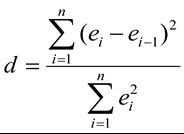

In [ ]:
# @title
X = curve.iloc[:, 0].values
y = curve.iloc[:, 1].values
dL = 1.366
dU = 1.462
# Ajustar o modelo de regressão
slope, intercept, _, _, _ = stats.linregress(X, y)
y_pred = intercept + slope * X
residuals = y - y_pred

# Calcular a estatística de Durbin-Watson manualmente
diff_resid = np.diff(residuals)
dcalc = np.sum(diff_resid**2) / np.sum(residuals**2)
dcalc_df = pd.DataFrame([dcalc], index=['D-calculado'])

if (dcalc < dL):
  resultado = 'Há correlação positiva'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação Positiva'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])
elif (dcalc > dU):
  resultado = 'Não há correlação positiva'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação Positiva'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])
elif (dL < dcalc < dU):
  resultado = 'Teste inconclusivo'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação Positiva'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
if ((4 - dcalc) < dL):
  resultado = 'Há correlação negativa'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação negativa'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])
elif ((4 - dcalc) > dU):
  resultado = 'Não há correlação negativa'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação negativa'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])
elif (dL < (4 - dcalc) < dU):
  resultado = 'Teste inconclusivo'
  resultado_df = pd.DataFrame([resultado], index = ['Correlação negativa'])
  dcalc_df = pd.concat([dcalc_df, resultado_df])

dcalc_df.rename(columns={0: 'Resultado'}, inplace = True)
dcalc_df


,Resultado
D-calculado,0.327124
Correlação Positiva,Há correlação positiva
Correlação negativa,Não há correlação negativa
